In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from set_axes import set_ax

The model we initially considered is the Susceptible-Infected-Recovered (SIR). A slight generalization of it is the Susceptible-Infected-Exposed-Recovered (SIER). Since there is enough information available about the incubation period of Covid-19, it might be worth implementing both in first place. 
Starting with SIR, the dynamic equations are given by:
$$
\dot{S} = -\frac{\beta}{N} SI \\
\dot{I} = \frac{\beta}{N} SI - \gamma I \\
\dot{R} = \gamma I \\
S + I + R = N
$$
Where $R_0 = \beta/\gamma$ represents the average growth rate of the virus.
For a discrete time model a forwards Euler integration should suffice. We introduce the SIR class for an easier API. The following objects can be used for the evolution of the population within a single compartment of the population.

In [3]:
class CompartmentManager(object):
    """Supposed to take care of arbitrary many cells once implemented"""
    
    def __init__(self):
        pass


class SRI(object):
    
    def __init__(self, beta=0.2, gamma=0.5, S0=999, I0=1, R0=0):
        self.S0 = S0
        self.I0 = I0
        self.R0 = R0
        self.beta = beta
        self.gamma = gamma
        self.reset()
        self.N = S0 + I0 + R0
        
    def increments(self, other=None, link=0.1):
        I = self.currentI if other is None else self.currentI + link*other.currentI
        deltaS = -self.beta*self.currentS*I/self.N
        deltaR = self.gamma*self.currentI
        deltaI = -deltaS - deltaR
        return (deltaS, deltaI, deltaR)
    
    def integrate(self):
        pass
        
    def evolve(self, days, tqdm=False):
        if tqdm:
            for i in tqdm(range(days)):
                self.integrate()
        else:
            for i in range(days):
                self. integrate()
                
    def reset(self):
        self._S = [self.S0]
        self._I = [self.I0]
        self._R = [self.R0]
    
    @property
    def currentS(self):
        return self._S[-1]
    
    @property
    def currentI(self):
        return self._I[-1]
    
    @property
    def currentR(self):
        return self._R[-1]
    
    @property
    def time_elapsed(self):
        return len(self.S)
    
    @property
    def time(self):
        return np.arange(self.time_elapsed)
    
    @property
    def S(self):
        return np.array(self._S)
    
    @property
    def I(self):
        return np.array(self._I)
    
    @property
    def R(self):
        return np.array(self._R)
        
        
class DeterministicSRI(SRI):
    
    def __init__(self, **kargs):
        super().__init__(**kargs)
        
    def integrate(self, other=None, link=0.1):
        (deltaS, deltaI, deltaR) = self.increments(other=other, link=link)
        newS = self.currentS + deltaS
        newI = self.currentI + deltaI
        newR = self.currentR + deltaR
        self._S.append(newS)
        self._I.append(newI)
        self._R.append(newR)
            
            
class StochasticSRI(SRI):
    
    def __init__(self, **kargs):
        super().__init__(**kargs)
    
    def integrate(self, other=None, link=0.1):
        (deltaS, deltaI, deltaR) = self.increments(other=other, link=link)
        jumpS = -min(np.random.poisson(lam=np.abs(deltaS)), self.currentS)
        jumpR = min(np.random.poisson(lam=np.abs(deltaR)), self.currentI)
        jumpI = -(jumpS + jumpR)
        newS = self.currentS + jumpS
        newI = self.currentI + jumpI
        newR = self.currentR + jumpR
        self._S.append(newS)
        self._I.append(newI)
        self._R.append(newR)

### Deterministic Model

Created to play around with parameters

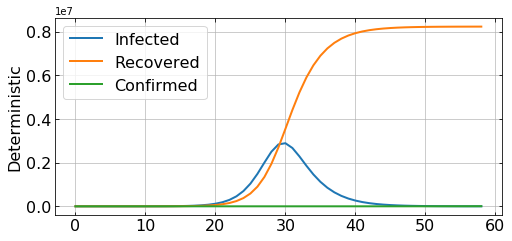

In [97]:
params = {'beta' : 0.9, 'gamma' : 0.3, 'S0' : 8570000, 'I0' : 10, 'R0' : 0}
model = DeterministicSRI(**params)
model.evolve(days=58)

xlabel = 'Days'
ylabel = 'Deterministic'
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(211)
#ax.plot(model.time, model.S, linewidth=2, label='Susceptible')
ax.plot(model.time, model.I, linewidth=2, label='Infected')
ax.plot(model.time, model.R, linewidth=2, label='Recovered')
ax.plot(model.time, confirmed, linewidth=2, label='Confirmed')

set_ax(ax, ylabel=ylabel, legend=True)
plt.show()

### Comparing deterministic and stochastic SRI models

In [4]:
# example use
params = {'beta' : 0.5, 'gamma' : 0.3, 'S0' : 999, 'I0' : 1, 'R0' : 0}
model1 = DeterministicSRI(**params)
model1.evolve(days=100)
model2 = StochasticSRI(**params)
model2.evolve(days=100)

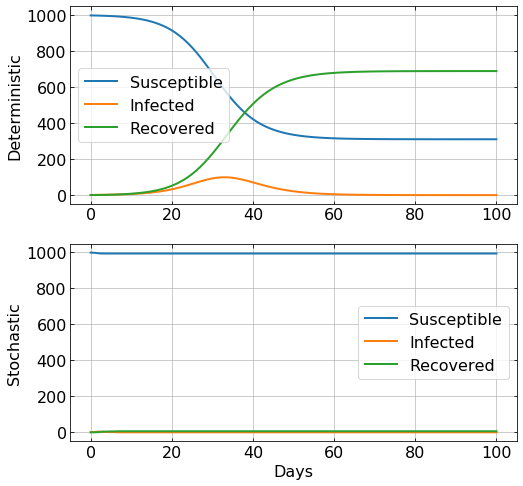

In [5]:
xlabel = 'Days'
ylabel1 = 'Deterministic'
ylabel2 = 'Stochastic'
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(model1.time, model1.S, linewidth=2, label='Susceptible')
ax1.plot(model1.time, model1.I, linewidth=2, label='Infected')
ax1.plot(model1.time, model1.R, linewidth=2, label='Recovered')
ax2.plot(model2.time, model2.S, linewidth=2, label='Susceptible')
ax2.plot(model2.time, model2.I, linewidth=2, label='Infected')
ax2.plot(model2.time, model2.R, linewidth=2, label='Recovered')
set_ax(ax1, ylabel=ylabel1, legend=True)
set_ax(ax2, xlabel=xlabel, ylabel=ylabel2, legend=True)
plt.show()

### Two deterministic cells interacting together

In [28]:
# interacting cells

params = {'beta' : 0.5, 'gamma' : 0.3, 'S0' : 999, 'I0' : 1, 'R0' : 0}
params2 = {'beta' : 0.5, 'gamma' : 0.3, 'S0' : 1000, 'I0' : 0, 'R0' : 0}
cell1 = DeterministicSRI(**params)
cell2 = DeterministicSRI(**params2)
link = 0.000001
days = 150

for i in range(days):
    cell1.integrate(other=cell2, link=link)
    cell2.integrate(other=cell1, link=link)

**Questions to answer**:
1. Determine Measure $m_1$ with which we should start
2. Does
$P(\text{child infects elderly}|\text{Measure } m_k \text{ is in place}) == P(\text{elderly infects child}|\text{Measure } m_k \text{ is in place})$
3. Determine initial variables in the context of the covid-19, i.e. $\beta, \gamma$
4. Set$ S_0, I_0, R_0 $ in function of the population under study (Switzerland or Italy)


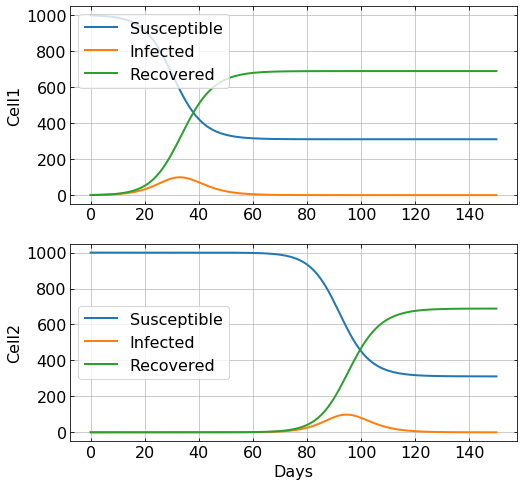

In [29]:
xlabel = 'Days'
ylabel1 = 'Cell1'
ylabel2 = 'Cell2'
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(cell1.time, cell1.S, linewidth=2, label='Susceptible')
ax1.plot(cell1.time, cell1.I, linewidth=2, label='Infected')
ax1.plot(cell1.time, cell1.R, linewidth=2, label='Recovered')
ax2.plot(cell2.time, cell2.S, linewidth=2, label='Susceptible')
ax2.plot(cell2.time, cell2.I, linewidth=2, label='Infected')
ax2.plot(cell2.time, cell2.R, linewidth=2, label='Recovered')
set_ax(ax1, ylabel=ylabel1, legend=True)
set_ax(ax2, xlabel=xlabel, ylabel=ylabel2, legend=True)
plt.show()

## Finding optimal parameters

In [72]:
import pandas as pd
confirmed = pd.read_csv('Corona-Virus-Dataset/time_series_covid_19_confirmed.csv')

In [73]:
confirmed = list(confirmed[confirmed['Country/Region'] == 'Switzerland'].iloc[0,4:])

In [76]:
days = len(confirmed)

In [46]:
#Residual Sum of Squares
def rss(pred, true):
    """pred: array, value we predict (i.e. number of confirmed cases/number of deaths)
       true: array, actual value (i.e. real number of confirmed cases/number of deaths)"""
    return np.sum(np.square(pred-true))

In [90]:
gammas = np.arange(0.0, 0.5, 0.0001)
betas = np.arange(0, 0.3, 0.0001)

M = np.zeros((len(gammas), len(betas)))

for i, g in tqdm(enumerate(gammas)):
    for j, b in enumerate(betas):
        
        params = params = {'beta' : b, 'gamma' : g, 'S0' : 8570000, 'I0' : 10, 'R0' : 0}
        model = DeterministicSRI(**params)
        model.evolve(days=days-1)
        
        M[i,j] = rss(model.I, confirmed)
        
        


0it [00:00, ?it/s]
1it [00:00,  1.54it/s]
2it [00:01,  1.45it/s]
3it [00:01,  1.54it/s]
4it [00:02,  1.61it/s]
5it [00:03,  1.54it/s]
6it [00:03,  1.51it/s]
7it [00:04,  1.51it/s]
8it [00:05,  1.54it/s]
9it [00:05,  1.62it/s]
10it [00:06,  1.66it/s]
11it [00:06,  1.70it/s]
12it [00:07,  1.73it/s]
13it [00:07,  1.76it/s]
14it [00:08,  1.69it/s]
15it [00:09,  1.70it/s]
16it [00:09,  1.66it/s]
17it [00:10,  1.66it/s]
18it [00:11,  1.67it/s]
19it [00:11,  1.69it/s]
20it [00:12,  1.67it/s]
21it [00:12,  1.65it/s]
22it [00:13,  1.68it/s]
23it [00:14,  1.66it/s]
24it [00:14,  1.65it/s]
25it [00:15,  1.69it/s]
26it [00:15,  1.73it/s]
27it [00:16,  1.64it/s]
28it [00:17,  1.67it/s]
29it [00:17,  1.50it/s]
30it [00:18,  1.54it/s]
31it [00:19,  1.58it/s]
32it [00:19,  1.62it/s]
33it [00:20,  1.68it/s]
34it [00:20,  1.72it/s]
35it [00:21,  1.73it/s]
36it [00:21,  1.74it/s]
37it [00:22,  1.75it/s]
38it [00:22,  1.78it/s]
39it [00:23,  1.71it/s]
40it [00:24,  1.69it/s]
41it [00:24,  1.71it/s]
42it 

296it [03:15,  1.76it/s]
297it [03:15,  1.77it/s]
298it [03:16,  1.78it/s]
299it [03:16,  1.77it/s]
300it [03:17,  1.76it/s]
301it [03:18,  1.74it/s]
302it [03:18,  1.76it/s]
303it [03:19,  1.78it/s]
304it [03:19,  1.78it/s]
305it [03:20,  1.78it/s]
306it [03:20,  1.75it/s]
307it [03:21,  1.70it/s]
308it [03:22,  1.73it/s]
309it [03:22,  1.76it/s]
310it [03:23,  1.74it/s]
311it [03:23,  1.74it/s]
312it [03:24,  1.72it/s]
313it [03:24,  1.74it/s]
314it [03:25,  1.75it/s]
315it [03:25,  1.77it/s]
316it [03:26,  1.80it/s]
317it [03:27,  1.81it/s]
318it [03:27,  1.77it/s]
319it [03:28,  1.77it/s]
320it [03:28,  1.76it/s]
321it [03:29,  1.76it/s]
322it [03:29,  1.77it/s]
323it [03:30,  1.79it/s]
324it [03:31,  1.81it/s]
325it [03:31,  1.81it/s]
326it [03:32,  1.78it/s]
327it [03:32,  1.78it/s]
328it [03:33,  1.77it/s]
329it [03:33,  1.76it/s]
330it [03:34,  1.73it/s]
331it [03:35,  1.74it/s]
332it [03:35,  1.75it/s]
333it [03:36,  1.77it/s]
334it [03:36,  1.75it/s]
335it [03:37,  1.76it/s]


588it [06:04,  1.73it/s]
589it [06:04,  1.62it/s]
590it [06:05,  1.62it/s]
591it [06:06,  1.58it/s]
592it [06:06,  1.57it/s]
593it [06:07,  1.58it/s]
594it [06:08,  1.60it/s]
595it [06:08,  1.59it/s]
596it [06:09,  1.65it/s]
597it [06:09,  1.67it/s]
598it [06:10,  1.71it/s]
599it [06:10,  1.74it/s]
600it [06:11,  1.76it/s]
601it [06:12,  1.77it/s]
602it [06:12,  1.77it/s]
603it [06:13,  1.77it/s]
604it [06:13,  1.78it/s]
605it [06:14,  1.77it/s]
606it [06:14,  1.79it/s]
607it [06:15,  1.81it/s]
608it [06:15,  1.81it/s]
609it [06:16,  1.81it/s]
610it [06:17,  1.77it/s]
611it [06:17,  1.77it/s]
612it [06:18,  1.77it/s]
613it [06:18,  1.77it/s]
614it [06:19,  1.77it/s]
615it [06:19,  1.78it/s]
616it [06:20,  1.80it/s]
617it [06:21,  1.80it/s]
618it [06:21,  1.78it/s]
619it [06:22,  1.76it/s]
620it [06:22,  1.75it/s]
621it [06:23,  1.73it/s]
622it [06:23,  1.72it/s]
623it [06:24,  1.75it/s]
624it [06:25,  1.75it/s]
625it [06:25,  1.77it/s]
626it [06:26,  1.77it/s]
627it [06:26,  1.75it/s]


880it [08:56,  1.83it/s]
881it [08:57,  1.84it/s]
882it [08:57,  1.83it/s]
883it [08:58,  1.83it/s]
884it [08:58,  1.78it/s]
885it [08:59,  1.78it/s]
886it [08:59,  1.77it/s]
887it [09:00,  1.78it/s]
888it [09:01,  1.79it/s]
889it [09:01,  1.80it/s]
890it [09:02,  1.80it/s]
891it [09:02,  1.78it/s]
892it [09:03,  1.79it/s]
893it [09:03,  1.80it/s]
894it [09:04,  1.82it/s]
895it [09:04,  1.82it/s]
896it [09:05,  1.81it/s]
897it [09:05,  1.79it/s]
898it [09:06,  1.80it/s]
899it [09:07,  1.79it/s]
900it [09:07,  1.80it/s]
901it [09:08,  1.81it/s]
902it [09:08,  1.80it/s]
903it [09:09,  1.81it/s]
904it [09:09,  1.80it/s]
905it [09:10,  1.81it/s]
906it [09:10,  1.81it/s]
907it [09:11,  1.82it/s]
908it [09:12,  1.80it/s]
909it [09:12,  1.80it/s]
910it [09:13,  1.81it/s]
911it [09:13,  1.82it/s]
912it [09:14,  1.81it/s]
913it [09:14,  1.79it/s]
914it [09:15,  1.72it/s]
915it [09:16,  1.68it/s]
916it [09:16,  1.67it/s]
917it [09:17,  1.66it/s]
918it [09:17,  1.69it/s]
919it [09:18,  1.69it/s]


1166it [11:44,  1.83it/s]
1167it [11:44,  1.82it/s]
1168it [11:45,  1.81it/s]
1169it [11:45,  1.80it/s]
1170it [11:46,  1.81it/s]
1171it [11:46,  1.77it/s]
1172it [11:47,  1.80it/s]
1173it [11:48,  1.78it/s]
1174it [11:48,  1.80it/s]
1175it [11:49,  1.81it/s]
1176it [11:49,  1.76it/s]
1177it [11:50,  1.71it/s]
1178it [11:50,  1.74it/s]
1179it [11:51,  1.78it/s]
1180it [11:51,  1.78it/s]
1181it [11:52,  1.80it/s]
1182it [11:53,  1.81it/s]
1183it [11:53,  1.82it/s]
1184it [11:54,  1.82it/s]
1185it [11:54,  1.82it/s]
1186it [11:55,  1.83it/s]
1187it [11:55,  1.84it/s]
1188it [11:56,  1.84it/s]
1189it [11:56,  1.85it/s]
1190it [11:57,  1.85it/s]
1191it [11:57,  1.85it/s]
1192it [11:58,  1.77it/s]
1193it [11:59,  1.72it/s]
1194it [11:59,  1.70it/s]
1195it [12:00,  1.71it/s]
1196it [12:01,  1.66it/s]
1197it [12:01,  1.70it/s]
1198it [12:02,  1.72it/s]
1199it [12:02,  1.73it/s]
1200it [12:03,  1.77it/s]
1201it [12:03,  1.79it/s]
1202it [12:04,  1.74it/s]
1203it [12:04,  1.72it/s]
1204it [12:0

1448it [14:53,  1.64it/s]
1449it [14:54,  1.64it/s]
1450it [14:54,  1.62it/s]
1451it [14:55,  1.59it/s]
1452it [14:56,  1.62it/s]
1453it [14:56,  1.62it/s]
1454it [14:57,  1.66it/s]
1455it [14:58,  1.66it/s]
1456it [14:58,  1.63it/s]
1457it [14:59,  1.63it/s]
1458it [14:59,  1.61it/s]
1459it [15:00,  1.66it/s]
1460it [15:01,  1.58it/s]
1461it [15:01,  1.55it/s]
1462it [15:02,  1.55it/s]
1463it [15:03,  1.60it/s]
1464it [15:03,  1.60it/s]
1465it [15:04,  1.67it/s]
1466it [15:04,  1.70it/s]
1467it [15:05,  1.68it/s]
1468it [15:06,  1.50it/s]
1469it [15:07,  1.21it/s]
1470it [15:08,  1.05it/s]
1471it [15:09,  1.14it/s]
1472it [15:10,  1.14it/s]
1473it [15:10,  1.25it/s]
1474it [15:11,  1.34it/s]
1475it [15:12,  1.41it/s]
1476it [15:12,  1.47it/s]
1477it [15:13,  1.55it/s]
1478it [15:13,  1.59it/s]
1479it [15:14,  1.60it/s]
1480it [15:15,  1.63it/s]
1481it [15:15,  1.69it/s]
1482it [15:16,  1.73it/s]
1483it [15:16,  1.61it/s]
1484it [15:17,  1.62it/s]
1485it [15:18,  1.56it/s]
1486it [15:1

1730it [17:42,  1.81it/s]
1731it [17:42,  1.80it/s]
1732it [17:43,  1.81it/s]
1733it [17:43,  1.82it/s]
1734it [17:44,  1.83it/s]
1735it [17:45,  1.77it/s]
1736it [17:45,  1.79it/s]
1737it [17:46,  1.81it/s]
1738it [17:46,  1.82it/s]
1739it [17:47,  1.79it/s]
1740it [17:47,  1.77it/s]
1741it [17:48,  1.77it/s]
1742it [17:48,  1.79it/s]
1743it [17:49,  1.80it/s]
1744it [17:50,  1.78it/s]
1745it [17:50,  1.80it/s]
1746it [17:51,  1.81it/s]
1747it [17:51,  1.81it/s]
1748it [17:52,  1.82it/s]
1749it [17:52,  1.82it/s]
1750it [17:53,  1.83it/s]
1751it [17:53,  1.84it/s]
1752it [17:54,  1.84it/s]
1753it [17:54,  1.84it/s]
1754it [17:55,  1.85it/s]
1755it [17:56,  1.85it/s]
1756it [17:56,  1.84it/s]
1757it [17:57,  1.84it/s]
1758it [17:57,  1.85it/s]
1759it [17:58,  1.84it/s]
1760it [17:58,  1.85it/s]
1761it [17:59,  1.84it/s]
1762it [18:00,  1.65it/s]
1763it [18:00,  1.66it/s]
1764it [18:01,  1.67it/s]
1765it [18:01,  1.69it/s]
1766it [18:02,  1.71it/s]
1767it [18:03,  1.67it/s]
1768it [18:0

2012it [20:21,  1.81it/s]
2013it [20:22,  1.82it/s]
2014it [20:22,  1.82it/s]
2015it [20:23,  1.81it/s]
2016it [20:23,  1.74it/s]
2017it [20:24,  1.78it/s]
2018it [20:24,  1.80it/s]
2019it [20:25,  1.82it/s]
2020it [20:25,  1.83it/s]
2021it [20:26,  1.84it/s]
2022it [20:27,  1.85it/s]
2023it [20:27,  1.84it/s]
2024it [20:28,  1.83it/s]
2025it [20:28,  1.84it/s]
2026it [20:29,  1.84it/s]
2027it [20:29,  1.85it/s]
2028it [20:30,  1.82it/s]
2029it [20:30,  1.82it/s]
2030it [20:31,  1.83it/s]
2031it [20:31,  1.83it/s]
2032it [20:32,  1.84it/s]
2033it [20:33,  1.85it/s]
2034it [20:33,  1.85it/s]
2035it [20:34,  1.85it/s]
2036it [20:34,  1.76it/s]
2037it [20:35,  1.70it/s]
2038it [20:36,  1.58it/s]
2039it [20:36,  1.62it/s]
2040it [20:37,  1.61it/s]
2041it [20:37,  1.56it/s]
2042it [20:38,  1.60it/s]
2043it [20:39,  1.67it/s]
2044it [20:39,  1.72it/s]
2045it [20:40,  1.74it/s]
2046it [20:40,  1.77it/s]
2047it [20:41,  1.80it/s]
2048it [20:41,  1.81it/s]
2049it [20:42,  1.83it/s]
2050it [20:4

2294it [23:01,  1.77it/s]
2295it [23:02,  1.78it/s]
2296it [23:02,  1.80it/s]
2297it [23:03,  1.79it/s]
2298it [23:03,  1.78it/s]
2299it [23:04,  1.78it/s]
2300it [23:04,  1.80it/s]
2301it [23:05,  1.80it/s]
2302it [23:05,  1.81it/s]
2303it [23:06,  1.81it/s]
2304it [23:06,  1.80it/s]
2305it [23:07,  1.82it/s]
2306it [23:08,  1.82it/s]
2307it [23:08,  1.82it/s]
2308it [23:09,  1.79it/s]
2309it [23:09,  1.79it/s]
2310it [23:10,  1.80it/s]
2311it [23:10,  1.75it/s]
2312it [23:11,  1.77it/s]
2313it [23:12,  1.76it/s]
2314it [23:12,  1.79it/s]
2315it [23:13,  1.81it/s]
2316it [23:13,  1.81it/s]
2317it [23:14,  1.83it/s]
2318it [23:14,  1.83it/s]
2319it [23:15,  1.83it/s]
2320it [23:15,  1.84it/s]
2321it [23:16,  1.84it/s]
2322it [23:16,  1.84it/s]
2323it [23:17,  1.84it/s]
2324it [23:18,  1.82it/s]
2325it [23:18,  1.83it/s]
2326it [23:19,  1.76it/s]
2327it [23:19,  1.66it/s]
2328it [23:20,  1.67it/s]
2329it [23:21,  1.66it/s]
2330it [23:21,  1.66it/s]
2331it [23:22,  1.71it/s]
2332it [23:2

2576it [26:05,  1.71it/s]
2577it [26:06,  1.71it/s]
2578it [26:06,  1.70it/s]
2579it [26:07,  1.72it/s]
2580it [26:08,  1.72it/s]
2581it [26:08,  1.71it/s]
2582it [26:09,  1.70it/s]
2583it [26:09,  1.68it/s]
2584it [26:10,  1.68it/s]
2585it [26:11,  1.62it/s]
2586it [26:11,  1.61it/s]
2587it [26:12,  1.65it/s]
2588it [26:13,  1.65it/s]
2589it [26:13,  1.64it/s]
2590it [26:14,  1.61it/s]
2591it [26:14,  1.64it/s]
2592it [26:15,  1.62it/s]
2593it [26:16,  1.64it/s]
2594it [26:16,  1.64it/s]
2595it [26:17,  1.62it/s]
2596it [26:17,  1.63it/s]
2597it [26:18,  1.65it/s]
2598it [26:19,  1.66it/s]
2599it [26:19,  1.67it/s]
2600it [26:20,  1.67it/s]
2601it [26:20,  1.68it/s]
2602it [26:21,  1.69it/s]
2603it [26:22,  1.69it/s]
2604it [26:22,  1.68it/s]
2605it [26:23,  1.68it/s]
2606it [26:23,  1.63it/s]
2607it [26:24,  1.66it/s]
2608it [26:25,  1.63it/s]
2609it [26:25,  1.64it/s]
2610it [26:26,  1.65it/s]
2611it [26:26,  1.65it/s]
2612it [26:27,  1.65it/s]
2613it [26:28,  1.66it/s]
2614it [26:2

2858it [28:58,  1.62it/s]
2859it [28:59,  1.64it/s]
2860it [28:59,  1.64it/s]
2861it [29:00,  1.65it/s]
2862it [29:01,  1.66it/s]
2863it [29:01,  1.67it/s]
2864it [29:02,  1.68it/s]
2865it [29:02,  1.66it/s]
2866it [29:03,  1.67it/s]
2867it [29:04,  1.67it/s]
2868it [29:04,  1.65it/s]
2869it [29:05,  1.61it/s]
2870it [29:05,  1.64it/s]
2871it [29:06,  1.67it/s]
2872it [29:07,  1.67it/s]
2873it [29:07,  1.67it/s]
2874it [29:08,  1.69it/s]
2875it [29:08,  1.67it/s]
2876it [29:09,  1.68it/s]
2877it [29:10,  1.65it/s]
2878it [29:10,  1.65it/s]
2879it [29:11,  1.57it/s]
2880it [29:12,  1.56it/s]
2881it [29:12,  1.53it/s]
2882it [29:13,  1.57it/s]
2883it [29:14,  1.60it/s]
2884it [29:14,  1.64it/s]
2885it [29:15,  1.63it/s]
2886it [29:15,  1.62it/s]
2887it [29:16,  1.64it/s]
2888it [29:17,  1.66it/s]
2889it [29:17,  1.67it/s]
2890it [29:18,  1.48it/s]
2891it [29:19,  1.26it/s]
2892it [29:20,  1.20it/s]
2893it [29:21,  1.24it/s]
2894it [29:21,  1.33it/s]
2895it [29:22,  1.42it/s]
2896it [29:2

3140it [31:51,  1.71it/s]
3141it [31:51,  1.71it/s]
3142it [31:52,  1.66it/s]
3143it [31:53,  1.66it/s]
3144it [31:53,  1.69it/s]
3145it [31:54,  1.67it/s]
3146it [31:54,  1.68it/s]
3147it [31:55,  1.71it/s]
3148it [31:55,  1.71it/s]
3149it [31:56,  1.71it/s]
3150it [31:57,  1.70it/s]
3151it [31:57,  1.71it/s]
3152it [31:58,  1.70it/s]
3153it [31:58,  1.72it/s]
3154it [31:59,  1.72it/s]
3155it [32:00,  1.69it/s]
3156it [32:00,  1.70it/s]
3157it [32:01,  1.71it/s]
3158it [32:01,  1.72it/s]
3159it [32:02,  1.73it/s]
3160it [32:02,  1.72it/s]
3161it [32:03,  1.71it/s]
3162it [32:04,  1.73it/s]
3163it [32:04,  1.73it/s]
3164it [32:05,  1.73it/s]
3165it [32:05,  1.73it/s]
3166it [32:06,  1.72it/s]
3167it [32:07,  1.70it/s]
3168it [32:07,  1.70it/s]
3169it [32:08,  1.70it/s]
3170it [32:08,  1.64it/s]
3171it [32:09,  1.65it/s]
3172it [32:10,  1.65it/s]
3173it [32:10,  1.68it/s]
3174it [32:11,  1.67it/s]
3175it [32:11,  1.67it/s]
3176it [32:12,  1.69it/s]
3177it [32:13,  1.69it/s]
3178it [32:1

3422it [34:45,  1.68it/s]
3423it [34:45,  1.70it/s]
3424it [34:46,  1.72it/s]
3425it [34:46,  1.70it/s]
3426it [34:47,  1.71it/s]
3427it [34:48,  1.72it/s]
3428it [34:48,  1.69it/s]
3429it [34:49,  1.68it/s]
3430it [34:49,  1.69it/s]
3431it [34:50,  1.69it/s]
3432it [34:51,  1.70it/s]
3433it [34:51,  1.72it/s]
3434it [34:52,  1.70it/s]
3435it [34:52,  1.66it/s]
3436it [34:53,  1.67it/s]
3437it [34:54,  1.68it/s]
3438it [34:54,  1.69it/s]
3439it [34:55,  1.70it/s]
3440it [34:55,  1.71it/s]
3441it [34:56,  1.60it/s]
3442it [34:57,  1.63it/s]
3443it [34:57,  1.65it/s]
3444it [34:58,  1.66it/s]
3445it [34:58,  1.67it/s]
3446it [34:59,  1.67it/s]
3447it [34:59,  1.69it/s]
3448it [35:00,  1.70it/s]
3449it [35:01,  1.71it/s]
3450it [35:01,  1.73it/s]
3451it [35:02,  1.73it/s]
3452it [35:02,  1.71it/s]
3453it [35:03,  1.71it/s]
3454it [35:04,  1.72it/s]
3455it [35:04,  1.71it/s]
3456it [35:05,  1.71it/s]
3457it [35:05,  1.72it/s]
3458it [35:06,  1.73it/s]
3459it [35:06,  1.74it/s]
3460it [35:0

3704it [37:37,  1.68it/s]
3705it [37:38,  1.68it/s]
3706it [37:38,  1.69it/s]
3707it [37:39,  1.68it/s]
3708it [37:39,  1.68it/s]
3709it [37:40,  1.67it/s]
3710it [37:40,  1.68it/s]
3711it [37:41,  1.69it/s]
3712it [37:42,  1.70it/s]
3713it [37:42,  1.70it/s]
3714it [37:43,  1.71it/s]
3715it [37:43,  1.70it/s]
3716it [37:44,  1.70it/s]
3717it [37:45,  1.71it/s]
3718it [37:45,  1.73it/s]
3719it [37:46,  1.74it/s]
3720it [37:46,  1.74it/s]
3721it [37:47,  1.75it/s]
3722it [37:47,  1.74it/s]
3723it [37:48,  1.68it/s]
3724it [37:49,  1.67it/s]
3725it [37:49,  1.68it/s]
3726it [37:50,  1.68it/s]
3727it [37:50,  1.69it/s]
3728it [37:51,  1.70it/s]
3729it [37:52,  1.71it/s]
3730it [37:52,  1.68it/s]
3731it [37:53,  1.67it/s]
3732it [37:53,  1.66it/s]
3733it [37:54,  1.68it/s]
3734it [37:55,  1.70it/s]
3735it [37:55,  1.70it/s]
3736it [37:56,  1.71it/s]
3737it [37:56,  1.72it/s]
3738it [37:57,  1.72it/s]
3739it [37:57,  1.71it/s]
3740it [37:58,  1.72it/s]
3741it [37:59,  1.71it/s]
3742it [37:5

3986it [40:23,  1.70it/s]
3987it [40:24,  1.69it/s]
3988it [40:24,  1.71it/s]
3989it [40:25,  1.70it/s]
3990it [40:25,  1.71it/s]
3991it [40:26,  1.70it/s]
3992it [40:27,  1.71it/s]
3993it [40:27,  1.71it/s]
3994it [40:28,  1.66it/s]
3995it [40:28,  1.64it/s]
3996it [40:29,  1.64it/s]
3997it [40:30,  1.64it/s]
3998it [40:30,  1.64it/s]
3999it [40:31,  1.67it/s]
4000it [40:31,  1.68it/s]
4001it [40:32,  1.69it/s]
4002it [40:33,  1.68it/s]
4003it [40:33,  1.65it/s]
4004it [40:34,  1.67it/s]
4005it [40:35,  1.54it/s]
4006it [40:35,  1.42it/s]
4007it [40:36,  1.47it/s]
4008it [40:37,  1.35it/s]
4009it [40:38,  1.18it/s]
4010it [40:39,  1.24it/s]
4011it [40:39,  1.33it/s]
4012it [40:40,  1.41it/s]
4013it [40:41,  1.49it/s]
4014it [40:41,  1.56it/s]
4015it [40:42,  1.59it/s]
4016it [40:42,  1.63it/s]
4017it [40:43,  1.66it/s]
4018it [40:43,  1.66it/s]
4019it [40:44,  1.63it/s]
4020it [40:45,  1.61it/s]
4021it [40:45,  1.56it/s]
4022it [40:46,  1.61it/s]
4023it [40:47,  1.64it/s]
4024it [40:4

4268it [43:15,  1.61it/s]
4269it [43:16,  1.62it/s]
4270it [43:17,  1.59it/s]
4271it [43:17,  1.62it/s]
4272it [43:18,  1.65it/s]
4273it [43:18,  1.65it/s]
4274it [43:19,  1.67it/s]
4275it [43:20,  1.68it/s]
4276it [43:20,  1.68it/s]
4277it [43:21,  1.68it/s]
4278it [43:21,  1.69it/s]
4279it [43:22,  1.69it/s]
4280it [43:23,  1.68it/s]
4281it [43:23,  1.67it/s]
4282it [43:24,  1.65it/s]
4283it [43:24,  1.62it/s]
4284it [43:25,  1.64it/s]
4285it [43:26,  1.67it/s]
4286it [43:26,  1.69it/s]
4287it [43:27,  1.67it/s]
4288it [43:27,  1.68it/s]
4289it [43:28,  1.70it/s]
4290it [43:29,  1.67it/s]
4291it [43:29,  1.70it/s]
4292it [43:30,  1.69it/s]
4293it [43:30,  1.68it/s]
4294it [43:31,  1.68it/s]
4295it [43:31,  1.69it/s]
4296it [43:32,  1.68it/s]
4297it [43:33,  1.69it/s]
4298it [43:33,  1.70it/s]
4299it [43:34,  1.69it/s]
4300it [43:34,  1.68it/s]
4301it [43:35,  1.68it/s]
4302it [43:36,  1.69it/s]
4303it [43:36,  1.69it/s]
4304it [43:37,  1.68it/s]
4305it [43:37,  1.69it/s]
4306it [43:3

4550it [46:05,  1.75it/s]
4551it [46:06,  1.78it/s]
4552it [46:07,  1.77it/s]
4553it [46:07,  1.78it/s]
4554it [46:08,  1.79it/s]
4555it [46:08,  1.79it/s]
4556it [46:09,  1.82it/s]
4557it [46:09,  1.79it/s]
4558it [46:10,  1.80it/s]
4559it [46:11,  1.77it/s]
4560it [46:11,  1.75it/s]
4561it [46:12,  1.77it/s]
4562it [46:12,  1.77it/s]
4563it [46:13,  1.78it/s]
4564it [46:13,  1.79it/s]
4565it [46:14,  1.79it/s]
4566it [46:14,  1.77it/s]
4567it [46:15,  1.76it/s]
4568it [46:16,  1.77it/s]
4569it [46:16,  1.78it/s]
4570it [46:17,  1.76it/s]
4571it [46:17,  1.79it/s]
4572it [46:18,  1.80it/s]
4573it [46:18,  1.80it/s]
4574it [46:19,  1.82it/s]
4575it [46:19,  1.82it/s]
4576it [46:20,  1.81it/s]
4577it [46:21,  1.79it/s]
4578it [46:21,  1.79it/s]
4579it [46:22,  1.70it/s]
4580it [46:22,  1.70it/s]
4581it [46:23,  1.74it/s]
4582it [46:23,  1.75it/s]
4583it [46:24,  1.77it/s]
4584it [46:25,  1.75it/s]
4585it [46:25,  1.77it/s]
4586it [46:26,  1.77it/s]
4587it [46:26,  1.77it/s]
4588it [46:2

4832it [48:54,  1.70it/s]
4833it [48:55,  1.72it/s]
4834it [48:55,  1.73it/s]
4835it [48:56,  1.73it/s]
4836it [48:57,  1.71it/s]
4837it [48:57,  1.69it/s]
4838it [48:58,  1.67it/s]
4839it [48:58,  1.65it/s]
4840it [48:59,  1.65it/s]
4841it [49:00,  1.64it/s]
4842it [49:00,  1.66it/s]
4843it [49:01,  1.68it/s]
4844it [49:01,  1.68it/s]
4845it [49:02,  1.69it/s]
4846it [49:03,  1.70it/s]
4847it [49:03,  1.69it/s]
4848it [49:04,  1.70it/s]
4849it [49:04,  1.71it/s]
4850it [49:05,  1.71it/s]
4851it [49:06,  1.70it/s]
4852it [49:06,  1.71it/s]
4853it [49:07,  1.71it/s]
4854it [49:07,  1.72it/s]
4855it [49:08,  1.73it/s]
4856it [49:08,  1.70it/s]
4857it [49:09,  1.70it/s]
4858it [49:10,  1.71it/s]
4859it [49:10,  1.70it/s]
4860it [49:11,  1.68it/s]
4861it [49:11,  1.69it/s]
4862it [49:12,  1.67it/s]
4863it [49:13,  1.63it/s]
4864it [49:13,  1.55it/s]
4865it [49:14,  1.60it/s]
4866it [49:15,  1.62it/s]
4867it [49:15,  1.65it/s]
4868it [49:16,  1.67it/s]
4869it [49:16,  1.67it/s]
4870it [49:1

In [87]:
# Minimum  for gamma ranging from 0 to 0.5 every 0.01 and beta 0.3 every 0.01: np.amin(M) == 13735842.997290796
# Minimum  for gamma ranging from 0 to 0.5 every 0.001 and beta 0.3 every 0.001: np.amin(M) == 11553693.198378215
# Minimum  for gamma ranging from 0 to 0.5 every 0.0001 and beta 0.3 every 0.0001: np.amin(M) == 11519246.337220717



13735842.997290796

In [91]:
np.amin(M)

11519246.337220717